# Clasificación

El cdataset FashionMNIST se utiliza comúnmente para entrenar y probar varios sistemas de aprendizaje automático.

El conjunto de datos contiene $70,000$ imágenes en escala de grises de $28\times 28$ de productos de moda de $10$ categorías, con $7,000$ imágenes por categoría. El conjunto de entrenamiento consta de $60,000$ imágenes y el conjunto de prueba consta de $10,000$ imágenes.

PyTorch ya nos da este conjunto de datros preprocesado 💗.

In [ ]:
# Nuevamente importamos los paquetes de cabecera
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# En esta ocasión usaremos nuevos métodos. El primero de ellos es importar
# todo lo relativo a FashionMNIST del paquete `torchvision`, pero además
# necesitaremos la API funcional de PyTorch.
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import FashionMNIST

# Por cuestiones de comprensión siempre es bueno darle un nombre a las
# capas, para eso ocuparemos el paquete
from collections import OrderedDict

# Para visualización y control de la aleatoriedad
import matplotlib.pyplot as plt
import numpy as np
import random

# Para estar a la moda con los nuevos estandares de Python 3
from typing import Iterable, Tuple

# Para cargar/guardar los mejores modelos
import os
from tempfile import TemporaryDirectory

Por cuestiones de reproducibilidad, nos gustaría tener los mismos resultados. Cabe aclarar que **no se recomienda hacer esto** en un entorno fuera de la enseñanza.

In [ ]:
random_seed = 1
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

Cargamos la GPU si está disponible, de lo contrario usamos el CPU 😞.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cpu device


## Dataset

En esta ocasión ya no es necesario crear el dataset desde cero, `torchvision` ya nos entrega el dataset *ready-to-use*, estandarizado, normalizado, acotado y con la división de train-test lista. Sin embargo, es necesario transformar cada imagen a un tensor y usar un `DataLoader` si queremos usar mini-batch.

In [ ]:

train_dataloader = DataLoader(
    FashionMNIST('/files/', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=64, shuffle=True
)
test_dataloader = DataLoader(
    FashionMNIST('/files/', train=False, download=True, transform=transforms.ToTensor()),
    batch_size=9, shuffle=True
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15088738.41it/s]


Extracting /files/FashionMNIST/raw/train-images-idx3-ubyte.gz to /files/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 282951.97it/s]


Extracting /files/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /files/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5063752.73it/s]


Extracting /files/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /files/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3469196.17it/s]


Extracting /files/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /files/FashionMNIST/raw



Pequeña función para saber el nombre de cada clase.

In [ ]:
def output_label(label):
  output_mapping = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
  }
  input = (label.item() if type(label) == torch.Tensor else label)
  return output_mapping[input]

Siempre es bueno ver cómo es nuestro dataset aunque sean imagenes. Es un poco difícil sacar alguna estadística respecto a su distribución pero ver a que nos enfrentamos puede darnos una idea de qué tan grande es la dificultad.

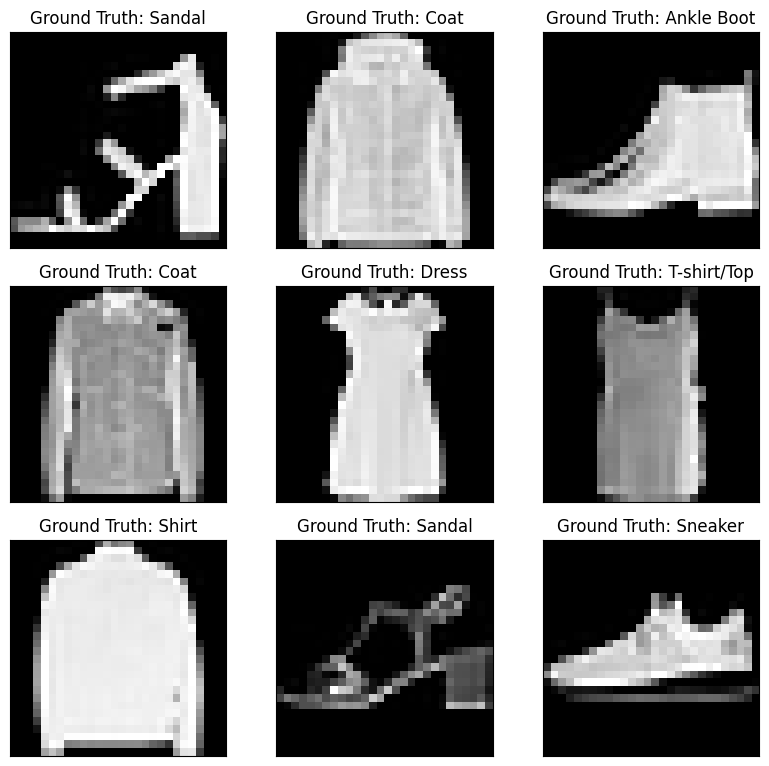

In [ ]:
sample_data, sample_targets = next(iter(train_dataloader))
sample_data, sample_targets = sample_data.to(device), sample_targets.to(device)

fig = plt.figure(figsize=(8, 8))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.tight_layout()
  plt.imshow(sample_data[i][0].cpu(), cmap='gray', interpolation='none')
  plt.title(f'Ground Truth: {output_label(sample_targets[i].cpu())}')
  plt.xticks([])
  plt.yticks([])

## Clasificador

Siempre es mejor ver para el futuro. Si nos damos cuenta que no son suficientes capas (o son demasiadas) muchos programadores agregan manualmente cada capa con una nueva variable.

Evitemos eso y usemos un ciclo, en el cual recibiremos el tamaño de las capas ocultas y con eso tener un solo modelo lo suficientemente flexible para experimentar.

Inicializa las capas internas usando He normal (que en PyTorch se usa `kaiming_normal_`) y la externa con Glorot uniform (`xavier_uniform_` en PyTorch) y todos los bias en zero. Además recuerda que las capas internas conmunmente usan ReLU y la externa SoftMax, pero **no agreges esta última función de activación** si tu objetivo es usar CrossEntropy, PyTorch trabaja con logits (si quieres la probabilidad mejor usa la API funcional en evaluación).

In [ ]:
class ClassifierFashionMNIST(nn.Module):
  def __init__(self, hidden_shapes: Iterable[int]) -> None:
    super().__init__()

    layers = [('flatten', nn.Flatten())]
    input_size = 784

    for i, shape in enumerate(hidden_shapes):
      layers.append((f'linear_{i}', nn.Linear(input_size, shape)))

      if i != len(hidden_shapes) - 1:
        nn.init.kaiming_normal_(layers[-1][1].weight, nonlinearity='relu')
        nn.init.zeros_(layers[-1][1].bias)
        layers.append((f'relu_{i}', nn.ReLU()))
      else:
        nn.init.xavier_uniform_(layers[-1][1].weight)
        nn.init.zeros_(layers[-1][1].bias)

      input_size = shape

    self.layers = nn.Sequential(OrderedDict(layers))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layers(x)

A diferencia de Tensorflow, en PyTorch debemos escribir el ciclo de entrenamiento desde cero. Se necesutan definir 4 objetos para realizar una época de entrenamiento:


*   El `DataLoader` que nos regresa un mini-batch de entrenamiento hasta acabar con todos los datos.
*   Nuestro modelo que hereda de `nn.Module`.
*   Nuestra función de pérdida (Cross entropy).
*   Nuestro optimizador (gradiente estocástico, i.e., SGD).

Otro aspecto importantízimo de PyTorch es que tiene dos tipos de comportamiento: el modo entrenamiento y el modo de evaluación. Asegurese antes de iniciar que se encuentre en modo entrenamiento llamando el método `model.train()` y limpiar los gradientes con `optimizer.zero_grad()` después de cada mini-batch (en serio, **recuerde esto**, se olvida más veces de lo que usted cree incluso para los más profesionales 😆).

En este caso deseamos regresar el valor de loss y el accuracy.

In [ ]:
def train(dataloader: DataLoader, model: nn.Module, loss_fn, optimizer) -> Tuple[float, float]:
  size = len(dataloader.dataset)
  model.train()
  epoch_loss = 0.0
  correct = 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    p = model(X)
    loss = loss_fn(p, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()
    p = F.softmax(p, dim=1)
    correct += (p.argmax(dim=1) == y).sum().item()

  return epoch_loss / len(dataloader), correct / len(dataloader.dataset)

Ahora, definamos el método para pruebas. Nuevamente requerimos de un `DataLoader`, del modelo y la función de pérdida pero no del optimizador. Para realizar inferencia, es necesario activar el método de evaluación con `model.eval()` pero aparte de eso **desactive los gradientes** con `torch.no_grad()`, en produción no querrá gastar memoria de GPU para algo que no necesitará (su cuenta de AWS podría llegar muy cara 🤑).

Una vez siguiendo esos pasos, el proceso de predicción es bastante similar solo que sin los pasos de optimización.

En este caso deseamos regresar el valor de loss y el accuracy

In [ ]:
def test(dataloader: DataLoader, model: nn.Module, loss_fn) -> Tuple[float, float]:
  model.eval()

  test_loss = 0.0
  correct = 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      p = F.softmax(model(X), dim=1)
      test_loss += loss_fn(p, y).item()
      correct += (p.argmax(dim=1) == y).sum().item()

  return test_loss / len(dataloader), correct / len(dataloader.dataset)

## Entrenamiento

Vamos a crear una red no tan profunda (puedes crearla más profunda con diferentes tamaños en las capas, solo cuidate del sobreajuste). Lo ideal sería experimentar e intentar con varias opciones, para eso la hicimos de definición variable.

In [ ]:
hidden_shapes = (32, 16, 10)
classifier = ClassifierFashionMNIST(hidden_shapes).to(device)
print(classifier)

ClassifierFashionMNIST(
  (layers): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear_0): Linear(in_features=784, out_features=32, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=32, out_features=16, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=16, out_features=10, bias=True)
  )
)


Programamos nuestro ciclo de entrenamiento. Con ayuda de nuestros métodos `train` y `test` realizaremos el cálculo de solo una época, debemos ciclar estos procedimientos durante todas nuestras épocas. Imprime los valores de loss y accuracy en cada época, eso te sirve para ver que tan mal o bien vas y cancelar manualmente si es necesario.

También usaremos early stopping, asegurese de guardar los mejores pesos y restaurarlos antes de salir.

Y dado que queremos un entrenamiento rápido, usaremos inicialmente una taza de aprendizaje alta para, porteriormente, reducirla exponencialmente y así controlar los grandes saltos.

In [ ]:
# Entrenaremos por 50 épocas, pero si la función de pérdida no mejora durante 5
# épocas, cancelaremos el entrenamiento y restauraremos el mejor modelo.
epochs = 50
early_patience = 5

# Usaremos cross entropy ya que es un problema de clasificación.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# En cada iteración guardaremos la función de pérdida por cuestiones de
# visualización
train_history = []
val_history = []

# Variables necesarias para early stopping
min_loss = float('inf')
early_epochs = 0

# No deseamos guardar basura en la PC, por eso creamos un directorio temporal
# para guardar los pesos
with TemporaryDirectory() as tmp_dir:
  tmp_path = os.path.join(tmp_dir, 'best_weights')

  # Repetimos este proceso para cada época
  for t in range(epochs):
    # Calculamos cross entropy y el accuracy tanto para el conjunto de
    # entrenamiento como el de validación y lo guardamos
    train_loss, train_acc = train(train_dataloader, classifier, loss_fn, optimizer)
    val_loss, val_acc = test(test_dataloader, classifier, loss_fn)
    train_history.append(train_loss)
    val_history.append(val_loss)

    # Avanzamos de igual manera nuestra taza de aprendizaje. Si lo deseas puedes
    # hacer esto cada número arbitrario de épocas (e incluso varias veces
    # dentro de una) pero lo mejor es hacerlo cada época.
    scheduler.step()

    # Imprimimos las estadísticas
    print(f'Epoch {t+1}: train avg loss: {train_loss:>8f}  train accucary {100 * train_acc:>.2f}% / val avg loss: {val_loss:>8f}  val accucary {100 * val_acc:>.2f}%')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}\n')

    # Si el valor de cross entropy del conjunto de validación es mayor al mejor
    # guardado hasta el momento, aumentamos el número de épocas sin mejorar.
    # Si estas han alcanzado el límite, restauramos los mejores pesos y
    # cancelamos el ciclo de entrenamiento
    if val_loss >= min_loss:
      early_epochs += 1
      if early_epochs == early_patience:
        classifier.load_state_dict(torch.load(tmp_path))
        break
    # Si val_loss mejoró, guardamos esos pesos y reiniciamos las cuentas de
    # épocas sin mejorar
    else:
      min_loss = val_loss
      early_epochs = 0
      torch.save(classifier.state_dict(), tmp_path)
print('Done!')

Epoch 1: train avg loss: 0.824926  train accucary 67.13% / val avg loss: 1.760453  val accucary 70.05%
Learning Rate: 0.450000

Epoch 2: train avg loss: 0.566531  train accucary 78.11% / val avg loss: 1.726089  val accucary 79.07%
Learning Rate: 0.405000

Epoch 3: train avg loss: 0.504024  train accucary 81.86% / val avg loss: 1.685126  val accucary 82.22%
Learning Rate: 0.364500

Epoch 4: train avg loss: 0.461887  train accucary 83.75% / val avg loss: 1.701184  val accucary 82.44%
Learning Rate: 0.328050

Epoch 5: train avg loss: 0.431676  train accucary 84.69% / val avg loss: 1.667566  val accucary 84.11%
Learning Rate: 0.295245

Epoch 6: train avg loss: 0.411719  train accucary 85.28% / val avg loss: 1.662805  val accucary 83.71%
Learning Rate: 0.265721

Epoch 7: train avg loss: 0.398648  train accucary 85.75% / val avg loss: 1.689722  val accucary 79.47%
Learning Rate: 0.239148

Epoch 8: train avg loss: 0.385964  train accucary 86.15% / val avg loss: 1.662358  val accucary 83.59%
L

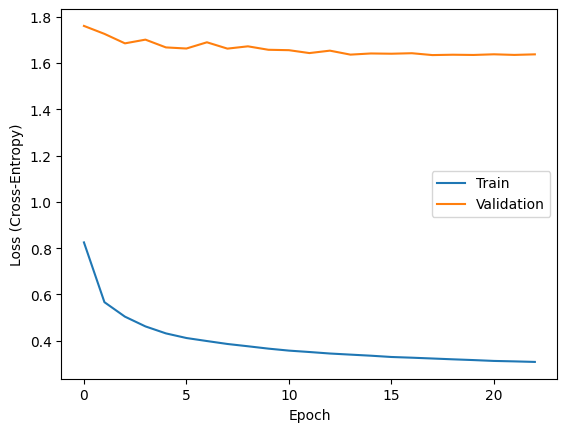

In [ ]:
plt.plot(train_history, label='Train')
plt.plot(val_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend();



---


## Interpretation

Para tener una idea clara de qué es lo que busca nuestra red neuronal debemos construir un mapa de calor. Entre más datos usemos para eso mejor, ya que nos da una idea clara de qué buscamos de manera general.

Normalmente los datos de entrada de una red neuronal **no requieren gradiente**, solo los pesos, pero podemos decirle manualmente a PyTorch que considere el gradiente de los datos de entrada.

En esta ocasión sí requerimos SoftMax, pero no requerimos usar otro estado más a nuestra red neuronal, solo requerimos el valor por lo que usamos la API funcional.

In [ ]:
selected_class = 8

# No queremos modificar los datos originales, trabajemos con una copia. Solo
# seleccionamos los datos que pertenecen a la clase que queremos estudiar.
test_input = sample_data.clone()
test_input = test_input[sample_targets == selected_class]

# Activamos los gradientes y los limpiamos (nunca está de más).
test_input.requires_grad = True
test_input.grad = None
classifier.zero_grad()

# Realizamos la predicción pero, en lugar de trabajar con logits, trabajaremos
# con probabilidades, por lo que utiliza la función SoftMax y selecciona solo
# la clase que queremos para aplicar backpropagation con `backward`.
p = classifier(test_input)
p = F.softmax(p, dim=1)[:, selected_class]
p.backward(torch.ones_like(p))

Debido a que no sabemos en qué rango están los valores, es mejor normarlizarlos en valores en el rango de $[0, 1]$.

In [ ]:
sensibility =  test_input.grad.abs().mean(dim=0).numpy()[0]
min_sensibility = sensibility.min()
max_sensibility = sensibility.max()

sensibility = (sensibility - min_sensibility) / (max_sensibility - min_sensibility)

Imprimimos el mapa de calor con una imagen de esa clase, para ver que tanto coincide.

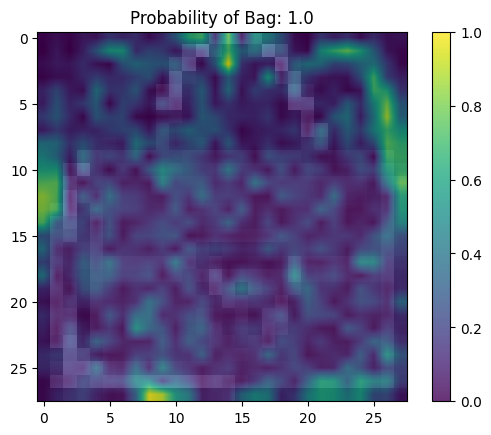

In [ ]:
selected_idx = 0
selected_image = test_input[selected_idx]
p_image = F.softmax(classifier(selected_image), dim=1)[0][selected_class].item()

plt.imshow(selected_image[0].detach().numpy(), cmap='gray', interpolation='none')
plt.imshow(sensibility, cmap='viridis', interpolation='bilinear', alpha=0.8)
plt.title(f'Probability of {output_label(selected_class)}: {p_image:>.1f}')
plt.colorbar()